# Assignment 05: Borůvka v. Kruskal

## Reading

- [Chapter 7](https://jeffe.cs.illinois.edu/teaching/algorithms/book/07-mst.pdf) from Jeff Erickson's book.
- [Kruskal's 1956 paper](./Kruskal.pdf) improving Borůvka's performance.


## “I Wrote the Code. You Measure It.”

You are given a fully working `MST` class (below) that computes a **minimum spanning tree** from an **adjacency matrix** using **two different techniques**:

* `boruvka()` — a barebones implementation that runs in about $\mathcal O(n^4)$.
* `kruskal()` — an implementation that runs in about $\mathcal O(n^2)$.

Your job is to **measure and compare their performance**. You should also study the implementation of Kruskal's technique and understand the *find-union* methods work.

---

## Learning goals

By the end of this assignment you should be able to:

* Generate valid random **undirected weighted graphs** as adjacency matrices
* Compute MSTs with two different algorithms and verify they match in weight
* Design timing experiments that are fair, repeatable, and interpretable
* Present results professionally: tables/plots + clear discussion + limitations

---

## What you are given

You are given the `MST` class exactly as shown in codebase below. Use it as-is.

**Important note:** the class accepts *any* diagonal sentinel for “no edge” (commonly `0`), and treats that same value elsewhere as “no edge” as well.

---

## Your tasks 

### 1) Write test code to generate graphs (adjacency matrices)

Write a function that generates **symmetric square matrices** representing **undirected graphs** with:

* **non-negative integer weights**
* **no self-loops** (all diagonal entries must be the no-edge sentinel)
* **symmetry** (`G[i][j] == G[j][i]`)
* a **configurable density** (sparse vs dense), or at minimum a consistent rule for whether an edge exists
* a consistent **no-edge sentinel** (use `0` unless you want to be adventurous)

You must ensure your graphs are **connected.**. *(Hint: what would the adjacency matrix of a disconnected graph look like?)*

**Deliverable:**
`make_graph(n: int, density: float, max_w: int, seed: int) -> list[list[int]]`

(If you don’t want to use `density`, you can design your own parameterization—but you must still produce a range of “more edges” vs “fewer edges” graphs.)

---

### 2) For each generated graph, compute MSTs using *both* techniques

For each test graph `G`:

1. Create an `MST(G)` object
2. Compute `T_b = mst.boruvka()`
3. Compute `T_k = mst.kruskal()`

Then verify correctness in a way that actually means something. A good minimum bar:

* Compute total weight of `T_b` and `T_k`
* They should match (for connected graphs)

**Deliverables:**

* `mst_weight(T: list[list[int]], no_edge: int) -> int`
* A correctness check that raises an error if weights differ

---

### 3) Time the techniques for various graph sizes

You must collect timing data for a range of `n` values. Pick a sequence that makes sense given that Borůvka here is ~O(n⁴). These are just examples below. Consider more/different sizes to showcase your testing/experimenting attitude.

* `n = 10, 20, 30, 40, 50` (safer)
* or `n = 25, 50, 75, 100` (spicier; might hurt)

For each `n`, run **multiple trials** (minimum 5; better 10+ if it’s not too slow). Use the same input graph for both algorithms in each trial.

Timing rules (read this twice):

* Don’t time graph generation together with MST computation unless you clearly separate it.
* Use a high-resolution timer (ok to import `time`)
* Keep everything else constant (same machine, same settings).
* Report **mean** and **standard deviation**.

**Deliverables:**

* A results table with at least: `n`, `trials`, `avg_boruvka`, `avg_kruskal`, plus variability
* At least one plot showing runtime vs `n` (two curves)

---

### 4) Analyze and discuss your findings professionally

Write a short report (300-600 words) that includes:

1. **Experimental setup**

   * How graphs were generated (density, weight range, connectedness strategy)
   * Which `n` values and how many trials
   * What timer you used
2. **Results**

   * Table(s)
   * Plot(s)
3. **Discussion**

   * Does observed growth resemble the expected complexity?
   * Where does Borůvka become impractical?
   * How does density affect each method (if you varied density)?
4. **Threats to validity / limitations**

   * Python overhead, caching effects, small n weirdness, etc.
   * Adjacency matrix representation isn’t the best for Kruskal in the real world
5. **Conclusion**

   * One paragraph: what you learned and what the data supports

---

## Restrictions / expectations

* You may write your test harness in **pure Python**. No imports other than `copy` and `time`. If you use Python tools to analyze/visualize data, you may import them as well (this applies mostly for `pandas` and `matplotlib`).
* Do **not** edit the `MST` algorithms.
* If you discover a bug: report it.

---

## Submission package

Submit:

1. `mst_experiment.py` **or** a link to a published notebook (do not upload an `.ipynb` on Sakai, please)
2. Your report (can be inside the notebook or attached as a separate document)
3. Output artifacts:

   * a nicely formatted table of results
   * at least one plot

---

## Grading rubric (suggested)

* **Graph generator correctness & constraints met:** 25%
* **Correctness checking (Borůvka vs Kruskal MST weight):** 15%
* **Timing methodology (fair, repeated trials, clean measurement):** 25%
* **Results presentation (tables/plots):** 15%
* **Professional analysis & discussion:** 20%

---

### Codebase


In [26]:
# 2345678901234567890123456789012345678901234567890123456789012345678901234567890

from copy import deepcopy


class MST:
    """A class with the methods necessary to produce a MST from the adjacency
    matrix of a weighted undirected graph. The class implements two techniques.
    First a barebone Boruvka method that runs in about $O(n^4)$ and next
    Kruska's technique that runs in about $O(n^2)$.
    """

    def __init__(self, G: list[list[int]]):
        """Initializes the MST object with the input graph G. Users are0
        expected to provide a symmetric square matrix with the diagonal
        values set to whatever semantic for no edge; this can be 0 or
        float('inf') which are the usual values; as long as the diagonal
        values are the same we're fine. Those values, found elsewere in
        the matrix will be viewed as no edge signals."""
        # Validate that the input graph is a non-empty square matrix
        if len(G) == 0 or len(G) != len(G[0]):
            raise ValueError("Input graph must be a non-empty square matrix")
        # Validate that the input graph is symmetric
        for i in range(len(G)):
            for j in range(len(G)):
                if G[i][j] != G[j][i]:
                    raise ValueError("Input graph must be undirected (symmetric)")
        # Validate that the input graph has no self-loops
        for i in range(len(G)):
            if G[i][i] != G[0][0]:
                raise ValueError("Input graph must have no self-loops")

        # Local copy of the input graph's adjacency matrix, so that we don't
        # accidentally modify the input graph. Also this local copy is
        # accessible to all methods of this class.
        self.G: list[list[int]] = deepcopy(G)
        # Shorthand notation for number of vertices, so that we don'try have to
        # keep writing len(self.G) all the time.
        self.n: int = len(self.G)
        # Shorthand of no-edge sentinel from input graph. Typicall we expect a 0
        # or an infinity as the no-edge sentinel, but we don't assume anything
        # here. We just take whatever is in G[0][0] as the no-edge sentinel.
        self.no_edge = G[0][0]
        # Adjacency matrix for MST. Initially it has no edges. This will be
        # populated as the algorithm progresses and will be the output
        # of the algorithm.
        self.T: list[list[int]] = [
            [self.no_edge for i in range(self.n)] for j in range(self.n)
        ]

        # Disjoint set data structures used by Kruskal. They live here because
        # we want them accessible to the private helper methods below.
        self._parent: list[int] = [i for i in range(self.n)]
        self._rank: list[int] = [0 for _ in range(self.n)]

    def _reachabilty(self, starting: int, graph: list[list[int]]) -> list[int]:
        """Determines the vertices of the input graph reachable from the
        starting vertex."""
        # List of reachable vertices
        reach: list[int] = []
        # List of vertices to explore next, primed with the starting vertex
        visit_next: list[int] = [starting]
        # Process every vertex in the visit_next list until it's empty.
        while len(visit_next) > 0:
            # Take a vertex out of the visit_next list. This can be the first
            # vertex in the list (operating it as a queue), the last vertex
            # (operating it as a stack), or any vertex with damn well please
            # (operating it as we like). All things being equal, stack is fine.
            vertex: int = visit_next.pop()
            if vertex not in reach:
                # Add this vertex to the reachable list
                reach.append(vertex)
                # Plan to visit this vertex's neighbors next
                for neighbor in range(self.n):
                    if graph[neighbor][vertex] != self.no_edge:
                        visit_next.append(neighbor)
        return reach  # Done!

    def _count_and_label(self):
        """Counts the components of the candidate MST (self.T) and labels its
        vertices with the component they belong to. For every vertex in the graph,
        track its component. The component label is the count value for each component
        when it was discovered. For example, if there are 3 components in the graph,
        the vertices in the first component will be labeled 1, those in the second
        component will be labeled 2, and those in the third component will be labeled 3.
        """
        # Count of components in the candidate MST
        count_of_components: int = 0
        # The component label for each vertex. Initialized to -1, meaning
        # that no vertex has been labeled yet.
        component_label: list[int] = [-1] * self.n
        # Remember the vertices we've seen so far. This is to avoid
        # double counting components.
        visited: list[int] = []
        # Process every vertex. If we haven't seen it before, it means
        # we've just found a new component.
        for vertex in range(self.n):
            if vertex not in visited:
                # We just found a new component, update the count. This count value
                # becomes the label for all vertices in this component.
                count_of_components += 1
                # Find everything we can reach from this vertex, because they'll be
                # in the same component
                reachable_from_vertex = self._reachabilty(vertex, self.T)
                # Add these reachable vertices to those visited, because
                # they are all in the same component and we don't want to
                # process them in the future.
                visited.extend(reachable_from_vertex)
                # The current component count becomes the label of all
                # these vertices
                for v in reachable_from_vertex:
                    component_label[v] = count_of_components
        return count_of_components, component_label  # Done

    # ------------------------------------------------------------------
    # Disjoint set operations for Kruskal. No imports. No nonsense.
    # ------------------------------------------------------------------

    def _ds_reset(self) -> None:
        """Resets the disjoint set structure so that every vertex is alone
        in its own little component, with zero baggage from previous runs."""
        self._parent = [i for i in range(self.n)]
        self._rank = [0 for _ in range(self.n)]

    def _ds_find(self, x: int) -> int:
        """Finds the representative of the set that contains x. We also do
        path compression, because we like our trees short and our finds fast."""
        while self._parent[x] != x:
            # Point x directly to its grandparent. This flattens the structure
            # over time and makes future finds cheaper.
            self._parent[x] = self._parent[self._parent[x]]
            x = self._parent[x]
        return x  # Done

    def _ds_union(self, a: int, b: int) -> bool:
        """Unions the sets of a and b. Returns True if we actually merged two
        different sets. Returns False if a and b were already in the same set."""
        ra = self._ds_find(a)
        rb = self._ds_find(b)
        merged = False
        if ra != rb:
            # Union by rank: attach the smaller tree under the bigger tree.
            if self._rank[ra] < self._rank[rb]:
                self._parent[ra] = rb
            elif self._rank[ra] > self._rank[rb]:
                self._parent[rb] = ra
            else:
                self._parent[rb] = ra
                self._rank[ra] += 1
            merged = True
        return merged  # Done

    def _edge_list(self) -> list[list[int]]:
        """Extracts the list of edges from the input graph. For an undirected
        graph stored as an adjacency matrix, we only look above the diagonal
        (u < v) so that we don't double-count edges like amateurs."""
        edges: list[list[int]] = []
        for u in range(self.n):
            for v in range(u + 1, self.n):
                if self.G[u][v] != self.no_edge:
                    # Represent an edge as [u, v, w]. Boring, but effective.
                    edges.append([u, v, self.G[u][v]])
        return edges  # Done

    def _sort_edges_by_weight(self, edges: list[list[int]]) -> list[list[int]]:
        """Sorts the edge list by weight, smallest first. This uses Python's
        built-in sort."""
        # The weight lives at index 2, because we said so in _edge_list().
        edges.sort(key=lambda e: e[2])
        return edges  # Done

    def boruvka(self):
        """The algorithm itself!"""
        # Initialize count of components in the candidate MST and also get the
        # labels for each vertex in it.
        count_of_components, component_label = self._count_and_label()
        while count_of_components > 1:
            # Initialize a list to hold the safe edges for the various components.
            # Here lies a YUGE! implementation question. How to represent a safe edge?
            safe_edge = [None] * (self.n + 1)
            # Find any two vertices u, v in different components. The loop examines
            # all pairs of vertices above the main diagonal of the adjacency matrix.
            # There is no reason to look below the main diagonal, because the graph is
            # undirected and the adjacency matrix is symmetric. Also there is no reason
            # to look at the main diagonal, because there are no self-loops in the graph.
            # So we look at all pairs (u,v) such that u < v. For every such pair,
            # if u and v are in different components, we consider edge (u,v) as
            # a candidate for the safe edge of the component of u and also for
            # the safe edge of the component of v.
            for u in range(self.n):
                for v in range(u + 1, self.n):
                    # Is there an edge between u and v in the input graph?
                    if self.G[u][v] != self.no_edge:
                        if component_label[u] != component_label[v]:
                            # Vertices u, v are in different components. Let's figure
                            # out the safe edge for the component of vertex u. We do
                            # things below in a verbose manner for clarity. We'll be
                            # more concise when we do the same for component of vertex v.
                            if safe_edge[component_label[u]] is None:
                                # There is no safe edge for this component yet, so let's
                                # assume that (u,v) is just it. And here is how to represent
                                # the safe edge of a component.
                                safe_edge[component_label[u]] = [u, v]
                            else:
                                # There is currently a safe edge for this vertex, but is
                                # it truly the safest? Let's find out. Is edge (u,v)
                                # safer than the current safe edge for this component?
                                current_component = component_label[u]
                                current_safe_edge = safe_edge[current_component]
                                a = current_safe_edge[0]  # safe edge vertex a
                                b = current_safe_edge[1]  # safe edge vertex b
                                # Look up input graph for weigh of edge (a,b)
                                current_weight = self.G[a][b]
                                # Which of two edges (a,b) and (u,v) is safer, ie,
                                # has the smallest weight?
                                if self.G[u][v] < current_weight:
                                    # If (u,v) is smaller than the existing safe
                                    # edge (a,b) make (u,v) the safe edge for the
                                    # current component.
                                    safe_edge[current_component] = [u, v]
                            # It's component v's turn now. We repeat the same
                            # logic as above, but for component of vertex v. The
                            # code is a bit less verbose this time.
                            if safe_edge[component_label[v]] is None:
                                safe_edge[component_label[v]] = [v, u]
                            else:
                                [a, b] = safe_edge[component_label[v]]
                                if self.G[v][u] < self.G[a][b]:
                                    safe_edge[component_label[v]] = [v, u]
            # Add all the safe edges to the candidate MST
            for edge in safe_edge:
                if edge is not None:
                    u = edge[0]
                    v = edge[1]
                    self.T[u][v] = self.G[u][v]
                    self.T[v][u] = self.G[v][u]
            # Recount the components and re-label the vertices
            count_of_components, component_label = self._count_and_label()
        return self.T  # Done!

    def kruskal(self):
        """Compute the MST using Kruskal's technique. The plan is simple:
        (1) list all edges, (2) sort them by weight, (3) add them in that order
        so long as they don't create a cycle. Disjoint sets do the cycle check.
        """
        # Start with a fresh empty MST matrix. No stale edges from past adventures.
        self.T = [[self.no_edge for i in range(self.n)] for j in range(self.n)]
        # Reset the disjoint set structure: everyone starts alone.
        self._ds_reset()

        # Step 1: Gather all edges from the input graph.
        edges = self._edge_list()
        # Step 2: Sort edges from smallest weight to largest weight.
        edges = self._sort_edges_by_weight(edges)

        # Step 3: Walk the edges in sorted order and take the safe ones.
        edges_added = 0
        i = 0
        while i < len(edges) and edges_added < self.n - 1:
            u, v, w = edges[i]
            # If u and v are in different components, then adding (u,v) is safe.
            if self._ds_union(u, v):
                self.T[u][v] = w
                self.T[v][u] = w
                edges_added += 1
            i += 1

        return self.T  # Done!

In [27]:
graph = [
    [_, _, _, 5, 1, _],
    [_, _, 20, 5, _, 10],
    [_, 20, _, 10, _, _],
    [5, 5, 10, _, _, 15],
    [1, _, _, _, _, 20],
    [_, 10, _, 15, 20, _],
]

test = MST(graph)
Tb = test.boruvka()
Tk = test.kruskal()
print(Tb)
print(Tk)

[['', '', '', 5, 1, ''], ['', '', '', 5, '', 10], ['', '', '', 10, '', ''], [5, 5, 10, '', '', ''], [1, '', '', '', '', ''], ['', 10, '', '', '', '']]
[['', '', '', 5, 1, ''], ['', '', '', 5, '', 10], ['', '', '', 10, '', ''], [5, 5, 10, '', '', ''], [1, '', '', '', '', ''], ['', 10, '', '', '', '']]


In [28]:
def make_graph(n: int, density: float, max_w: int, seed: int) -> list[list[int]]:
    """Generates a random undirected weighted graph as an adjacency matrix.
    The graph has n vertices, edge density of approximately `density`, and
    edge weights that are random integers from 1 to max_w. The no-edge
    sentinel is 0. The seed is used to make the graph generation deterministic."""
    import random

    random.seed(seed)
    G = [[0 for _ in range(n)] for _ in range(n)]
    for i in range(n):
        for j in range(i + 1, n):
            if random.random() < density:
                weight = random.randint(1, max_w)
                G[i][j] = weight
                G[j][i] = weight
    # Ensure the graph is connected by adding a spanning tree if necessary
    for i in range(1, n):
        if G[i][i - 1] == 0:
            weight = random.randint(1, max_w)
            G[i][i - 1] = weight
            G[i - 1][i] = weight
    return G

def mst_weight(T: list[list[int]], no_edge: int) -> int:
    test = MST(T)
    T_b = test.boruvka()
    T_k = test.kruskal()
    weight_b = sum(T_b[i][j] for i in range(len(T_b)) for j in range(i + 1, len(T_b)) if T_b[i][j] != no_edge)
    weight_k = sum(T_k[i][j] for i in range(len(T_k)) for j in range(i + 1, len(T_k)) if T_k[i][j] != no_edge)
    if weight_b != weight_k:
        raise ValueError(f"Borůvka and Kruskal produced different weights: {weight_b} vs {weight_k}")
    return weight_b

In [29]:
import time
import math


def time_algorithms(n_values, density, max_w, trials):
    results = []
    for n in n_values:
        boruvka_times = []
        kruskal_times = []
        for trial in range(trials):
            seed = trial  # Use trial number as seed for reproducibility
            G = make_graph(n, density, max_w, seed)
            mst = MST(G)

            start_time = time.perf_counter()
            mst.boruvka()
            end_time = time.perf_counter()
            boruvka_times.append(end_time - start_time)

            start_time = time.perf_counter()
            mst.kruskal()
            end_time = time.perf_counter()
            kruskal_times.append(end_time - start_time)

        avg_boruvka = sum(boruvka_times) / trials
        avg_kruskal = sum(kruskal_times) / trials

        var_boruvka = sum((t - avg_boruvka) ** 2 for t in boruvka_times) / trials
        var_kruskal = sum((t - avg_kruskal) ** 2 for t in kruskal_times) / trials
        sdev_boruvka = math.sqrt(var_boruvka)
        sdev_kruskal = math.sqrt(var_kruskal)

        results.append((n, trials, avg_boruvka, sdev_boruvka, avg_kruskal, sdev_kruskal))

    return results


def results_table(results):
    """Generate a results table from time_algorithms() output.

    Expects tuples in the format:
    (n, trials, avg_boruvka, sdev_boruvka, avg_kruskal, sdev_kruskal)

    Returns a pandas DataFrame with columns:
    n, trials, avg_boruvka, avg_kruskal, sdev_boruvka, sdev_kruskal
    """
    import pandas as pd

    rows = []
    for (n, trials, avg_boruvka, sdev_boruvka, avg_kruskal, sdev_kruskal) in results:
        rows.append(
            {
                "n": n,
                "trials": trials,
                "avg_boruvka": avg_boruvka,
                "avg_kruskal": avg_kruskal,
                "sdev_boruvka": sdev_boruvka,
                "sdev_kruskal": sdev_kruskal,
            }
        )
    return pd.DataFrame(rows)


def plot_results(results):
    """Plot average runtime (seconds) for Boruvka and Kruskal vs n using the
    output format from time_algorithms():
    (n, trials, avg_boruvka, sdev_boruvka, avg_kruskal, sdev_kruskal)."""
    import matplotlib.pyplot as plt

    n_vals = [row[0] for row in results]
    boruvka_avg = [row[2] for row in results]
    kruskal_avg = [row[4] for row in results]

    plt.figure(figsize=(8, 5))
    plt.plot(n_vals, boruvka_avg, marker="o", label="Boruvka (avg)")
    plt.plot(n_vals, kruskal_avg, marker="o", label="Kruskal (avg)")
    plt.xlabel("n (number of vertices)")
    plt.ylabel("Average time (seconds)")
    plt.title("Average MST runtime vs n (over trials)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [30]:
n_values = [25, 50, 75, 100]

results = time_algorithms(n_values, 0.2, 100, 20)
table = results_table(results)
display(table)

,n,trials,avg_boruvka,avg_kruskal,sdev_boruvka,sdev_kruskal
0,25,20,0.000484,0.000149,0.000223,0.000042
1,50,20,0.001480,0.000438,0.000430,0.000122
2,75,20,0.002718,0.000719,0.000290,0.000084
3,100,20,0.005504,0.001489,0.001637,0.000450


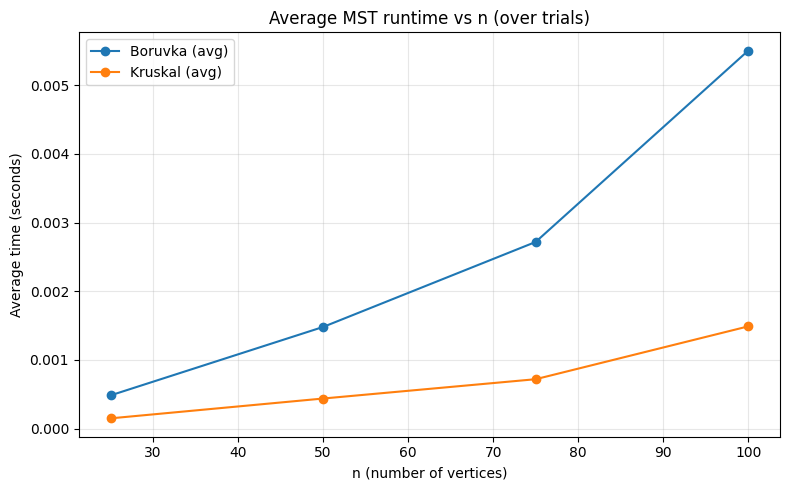

In [31]:
plot_results(results)


# Experimental setup

Graphs were generated using .2 density value and 1-100 weight range. Connectedness was validated by creating a spanning tree within the graph to connect separate components.

The n values selected were 25, 50, 75, 100. 20 trials of both Boruvka and Kruskal’s algorithm were performed for each n value. The timer used was the Python time library.

## Results
Generated by above notebook cells.

## Discussion
Observed growth closely resembles expected complexity. By performing an adequate number of trials, in my case 20, the generated graph easily reflects the Big-O running time of both Boruvka and Kruskal. Both algorithms run in polynomial time, and Boruvka shows O^4 growth, while Kruskal shows O^2 growth. While Boruvka’s algorithm was able to run in a reasonable amount of time on my machine, as n number of vertices grows exponentially Boruvka’s algorithm can easily become unwieldly and impractical to use.

## Limitations
Using a small number of n nodes may lead to inconsistent results when generating the graph. Also calculating the running time of the graph in a notebook locally on my computer may lead to inconsistent results. For example, running time results on my computer will differ from someone who runs my notebook on different hardware. Also, differences in Python versions and environments used lead to further variability that make it even more difficult to reproduce results.

Adjacency matrix representations are impractical for Kruskal’s algorithm due to the size of adjacency matrices and the speed to retrieve edges from adjacency matrices. Kruskal’s algorithm is dependent on listing edges, no matter the graph’s density. Since the space complexity of adjacency matrices is always O(V^2), this can lead to unnecessary space used to run Kruskal’s algorithm. Also, retrieving sorted edge lists used for Kruskal’s algorithm is slow using adjacency matrices. In order to retrieve an edge list from an adjacency matrix, it is necessary to traverse all vertices in the matrix and retrieve all edges that exist. Using an alternative implementation such as an adjacency list will make edge retrieval much faster (O(E)). With these limitations in mind, the adjacency matrix implementation of Kruskal’s algorithm may lead to additional overhead where the running time is not reflective of real-world use.

## Conclusion
I learned that the choice of algorithms is important to minimize the running time of graph algorithms. The theoretical running time of Boruvka and Kruskal’s algorithms, O^4 and O^2, is reflected in the practical results table and graph that I have generated using these algorithms. Choosing the most efficient algorithm when creating my code is necessary so that I can minimize running time as I increase the scale that my code is used in.
